In [ ]:
"""
TODO: 
    - Residual plots
    - Write baseline model as a class 
"""

from lightgbm import LGBMRegressor
import pandas as pd

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from feature_engine.encoding import OrdinalEncoder

from sklearn.pipeline import Pipeline

from src.data import (
    make_exog_features,
    split_data,
    prepare_feature_store_data_for_training,
)

from src.model import forwardfill_missing_values
from src.paths import TRANSFORMED_DATA_DIR

from src.config import BAS

data = pd.read_csv(
    TRANSFORMED_DATA_DIR / "ts_tabular_2022_10_to_2025_2.csv",
    parse_dates=["datetime"])

# Clean up data
data = data[data["ba_code"].isin(BAS)]
# Forward filling NaNs
data = forwardfill_missing_values(data)

data.head()

,datetime,demand,ba_code
0,2022-10-01,51628.0,AECI
1,2022-10-02,53127.0,AECI
2,2022-10-03,54708.0,AECI
3,2022-10-04,53345.0,AECI
4,2022-10-05,53356.0,AECI


In [7]:
demand = data.copy()
demand.dtypes

datetime    datetime64[ns]
demand             float64
ba_code             object
dtype: object

In [8]:
demand[demand["demand"] == -1]

,datetime,demand,ba_code


In [9]:
dtf = DatetimeFeatures(
    # the datetime variable
    variables="datetime",
    # the features we want to create
    features_to_extract=[
        "month",
        "week",
        "day_of_week",
        "day_of_month",
        "weekend",
    ],
    drop_original=False
)

# demand = dtf.fit_transform(demand)
# demand.head()

In [10]:
from sklearn.base import TransformerMixin

def wrapper(df: pd.DataFrame, transformer: TransformerMixin) -> pd.DataFrame:
    # Unique bas
    ba_codes = df["ba_code"].unique()
    
    # Iterate over each BA, fit_transform for each BA and concatenate
    output = pd.DataFrame()
    for ba_code in ba_codes:
        tmp = df.loc[df["ba_code"] == ba_code, :].copy()
        tmp = transformer.fit_transform(tmp)
        tmp["ba_code"] = ba_code
        output = pd.concat([output, tmp])

    return output

In [11]:
def get_lag_features(
    df: pd.DataFrame, 
    lags: list[int] = [1, 2, 3, 4, 5, 6, 7], 
    variables: list[str] = ["demand"],
    ) -> pd.DataFrame:
    
    # define lag transformer
    lf = LagFeatures(
        variables=variables,
        periods=lags,
        drop_original=False,
    )

    return wrapper(df, lf)


def get_window_features(
    df: pd.DataFrame, 
    window: list[int] = [3, 7, 14], 
    freq: str = None, 
    functions: list[str] = ["mean", "std", "max", "min"], 
    variables: list[str] = ["demand"],
    ) -> pd.DataFrame:
    
    winf = WindowFeatures(
        variables=variables, 
        window=window, 
        freq=freq, 
        functions=functions,
        missing_values="ignore",
    )
    
    return wrapper(df, winf)


In [12]:
from sklearn.preprocessing import FunctionTransformer


lagf = FunctionTransformer(get_lag_features, validate=False)
windf = FunctionTransformer(get_window_features, validate=False)
# Introduce missing date when using lags and windows so need to drop these NaNs
drop_missing = DropMissingData()

# Ordinal encoding for BA feature
ordinal_enc = OrdinalEncoder(variables=["ba_code"], encoding_method="arbitrary")

# Also drop the target from the training set
drop_target = DropFeatures(features_to_drop=["demand", "datetime"])

In [13]:
pipe = Pipeline(
    [
        ("datetime", dtf),
        ("lags", lagf),
        ("windf", windf),
        ("drop_missing", drop_missing),
        ("ordinal_enc", ordinal_enc),
        ("drop_target", drop_target),
    ]
)

In [14]:
demand_ = pipe.fit_transform(demand)

demand_.head()

,ba_code,datetime_month,datetime_week,datetime_day_of_week,datetime_day_of_month,datetime_weekend,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,...,demand_window_3_max,demand_window_3_min,demand_window_7_mean,demand_window_7_std,demand_window_7_max,demand_window_7_min,demand_window_14_mean,demand_window_14_std,demand_window_14_max,demand_window_14_min
14,0,10,41,5,15,1,54248.0,52091.0,53685.0,53944.0,...,54248.0,52091.0,52691.000000,1370.568252,54248.0,50391.0,52804.357143,1388.898158,54708.0,50246.0
15,0,10,41,6,16,1,52828.0,54248.0,52091.0,53685.0,...,54248.0,52091.0,53039.142857,926.560742,54248.0,51900.0,52890.071429,1347.116034,54708.0,50246.0
16,0,10,42,0,17,0,52323.0,52828.0,54248.0,52091.0,...,54248.0,52323.0,53099.571429,850.562727,54248.0,52091.0,52832.642857,1353.361718,54708.0,50246.0
17,0,10,42,1,18,0,58368.0,52323.0,52828.0,54248.0,...,58368.0,52323.0,53926.714286,2122.729667,58368.0,52091.0,53094.071429,1960.710800,58368.0,50246.0
18,0,10,42,2,19,0,66512.0,58368.0,52323.0,52828.0,...,66512.0,52323.0,55722.142857,5209.927364,66512.0,52091.0,54034.571429,4090.996751,66512.0,50246.0


In [15]:
demand.index

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       58950, 58951, 58952, 58953, 58954, 58955, 58956, 58957, 58958, 58959],
      dtype='int64', length=46640)

In [16]:
data.index

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       58950, 58951, 58952, 58953, 58954, 58955, 58956, 58957, 58958, 58959],
      dtype='int64', length=46640)

In [17]:
df = data.copy()

X = pipe.fit_transform(df)

In [18]:
X.head(), X.shape

(    ba_code  datetime_month  datetime_week  datetime_day_of_week  \
 14        0              10             41                     5   
 15        0              10             41                     6   
 16        0              10             42                     0   
 17        0              10             42                     1   
 18        0              10             42                     2   
 
     datetime_day_of_month  datetime_weekend  demand_lag_1  demand_lag_2  \
 14                     15                 1       54248.0       52091.0   
 15                     16                 1       52828.0       54248.0   
 16                     17                 0       52323.0       52828.0   
 17                     18                 0       58368.0       52323.0   
 18                     19                 0       66512.0       58368.0   
 
     demand_lag_3  demand_lag_4  ...  demand_window_3_max  demand_window_3_min  \
 14       53685.0       53944.0  ...        

In [19]:
# Over two years worth of data
df["datetime"].min(), df["datetime"].max()

(Timestamp('2022-10-01 00:00:00'), Timestamp('2025-02-26 00:00:00'))

In [20]:
# Use the final 6 months as a test set but also need the greatest lag/window in the past, which is currently 14 days
pd.Timestamp("2024-08-26") - pd.offsets.Day(14)

Timestamp('2024-08-12 00:00:00')

In [ ]:
train_end = pd.Timestamp("2024-08-26")

X_train = data.loc[data["datetime"] < train_end]
X_test = data.loc[data["datetime"] >= train_end - pd.offsets.Day(14)]

y_train = data.loc[data["datetime"] < train_end]["demand"]
y_test = data.loc[data["datetime"] >= train_end - pd.offsets.Day(14)]["demand"]

In [22]:
X_train["datetime"].min(), X_train["datetime"].max(), X_test["datetime"].min(), X_test["datetime"].max()

(Timestamp('2022-10-01 00:00:00'),
 Timestamp('2024-08-25 00:00:00'),
 Timestamp('2024-08-12 00:00:00'),
 Timestamp('2025-02-26 00:00:00'))

In [23]:
X_train_t = pipe.fit_transform(X_train)

In [24]:
# Dropped data when transforming pipeline so need to realign
y_train_t = y_train.loc[X_train_t.index]
y_train_t.shape, X_train_t.shape, all(y_train_t.index == X_train_t.index)

((36093,), (36093, 25), True)

In [36]:
from typing import Tuple

def split_data(df: pd.DataFrame, train_end: str, days_of_historic_data: int) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    data = df.copy()

    train_end = pd.Timestamp(train_end)

    X_train = data.loc[data["datetime"] < train_end]
    X_test = data.loc[
        data["datetime"] >= train_end - pd.offsets.Day(days_of_historic_data)
    ]

    y_train = data.loc[data["datetime"] < train_end]["demand"]
    y_test = data.loc[
        data["datetime"] >= train_end - pd.offsets.Day(days_of_historic_data)
    ]["demand"]
    
    return X_train, y_train, X_test, y_test

In [39]:
train_end = "2024-08-26"
days_of_historic_data = 14

X_train, y_train, X_test, y_test = split_data(data, train_end=train_end, days_of_historic_data=days_of_historic_data)

X_train["datetime"].min(), X_train["datetime"].max(), X_test["datetime"].min(), X_test["datetime"].max()

(Timestamp('2022-10-01 00:00:00'),
 Timestamp('2024-08-25 00:00:00'),
 Timestamp('2024-08-12 00:00:00'),
 Timestamp('2025-02-26 00:00:00'))

In [54]:
def transform_training_data(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, preprocessing_pipeline: Pipeline) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:

    # Fit and transform train set
    X_train_t = preprocessing_pipeline.fit_transform(X_train)
    # Align indexes
    y_train_t = y_train.loc[X_train_t.index]

    # Transform test set
    X_test_t = preprocessing_pipeline.transform(X_test)
    # Align indexes
    y_test_t = y_test.loc[X_test_t.index]

    assert all(y_train_t.index == X_train_t.index), "Indexes of target don't match features in training set"
    assert all(y_test_t.index == X_test_t.index), "Indexes of target don't match features in testing set"

    return X_train_t, y_train_t, X_test_t, y_test_t

In [55]:
X_train_t, y_train_t, X_test_t, y_test_t = transform_training_data(
    X_train, y_train, X_test, y_test, pipe
)

In [56]:
X_train_t.shape, y_train_t.shape, X_test_t.shape, y_test_t.shape

((36093, 25), (36093,), (9805, 25), (9805,))

In [43]:
lgbm = LGBMRegressor()

lgbm.fit(X_train_t, y_train_t)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5005
[LightGBM] [Info] Number of data points in the train set: 36093, number of used features: 25
[LightGBM] [Info] Start training from score 212957.347325


LGBMRegressor()

In [44]:
preds = lgbm.predict(X_train_t)
preds

array([52929.6001819 , 51670.15202193, 53560.54627478, ...,
        2733.12653119,  2395.50871293,  2551.86242308])

Text(0.5, 1.0, 'Forecast: train set')

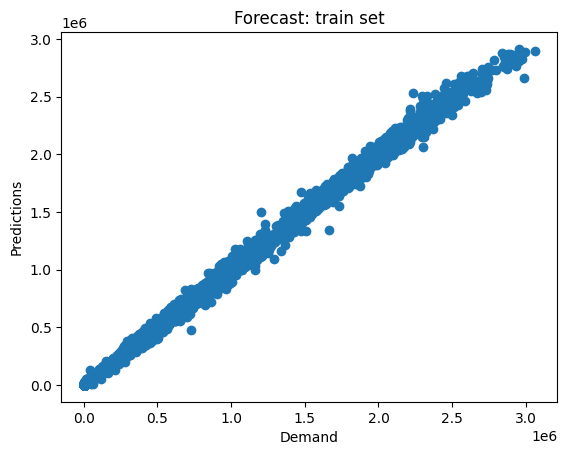

In [45]:
# Plot the predictions vs the truth.
import matplotlib.pyplot as plt

plt.scatter(y_train_t, preds)
plt.xlabel("Demand")
plt.ylabel("Predictions")
plt.title("Forecast: train set")

In [46]:
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(preds, y_train_t)

In [47]:
rmse

15570.004259075895

In [48]:
X_test_t = pipe.transform(X_test)
X_test_t.head()

,ba_code,datetime_month,datetime_week,datetime_day_of_week,datetime_day_of_month,datetime_weekend,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,...,demand_window_3_max,demand_window_3_min,demand_window_7_mean,demand_window_7_std,demand_window_7_max,demand_window_7_min,demand_window_14_mean,demand_window_14_std,demand_window_14_max,demand_window_14_min
695,0,8,35,0,26,0,71471.0,63731.0,59361.0,53575.0,...,71471.0,59361.0,60352.000000,6278.271923,71471.0,53575.0,63289.000000,6853.933267,73919.0,53575.0
696,0,8,35,1,27,0,76077.0,71471.0,63731.0,59361.0,...,76077.0,63731.0,62196.000000,8679.842299,76077.0,53575.0,64638.071429,7398.276550,76077.0,53575.0
697,0,8,35,2,28,0,77468.0,76077.0,71471.0,63731.0,...,77468.0,71471.0,65220.428571,9886.384406,77468.0,53575.0,65986.785714,7913.287377,77468.0,53575.0
698,0,8,35,3,29,0,74049.0,77468.0,76077.0,71471.0,...,77468.0,74049.0,67961.714286,9169.207903,77468.0,53575.0,66612.714286,8195.142599,77468.0,53575.0
699,0,8,35,4,30,0,75757.0,74049.0,77468.0,76077.0,...,77468.0,74049.0,71130.571429,6927.524615,77468.0,59361.0,66796.714286,8380.776120,77468.0,53575.0


In [49]:
preds_test = lgbm.predict(X_test_t)

In [50]:
y_test_t = y_test.loc[X_test_t.index]

Text(0.5, 1.0, 'Forecast: test set')

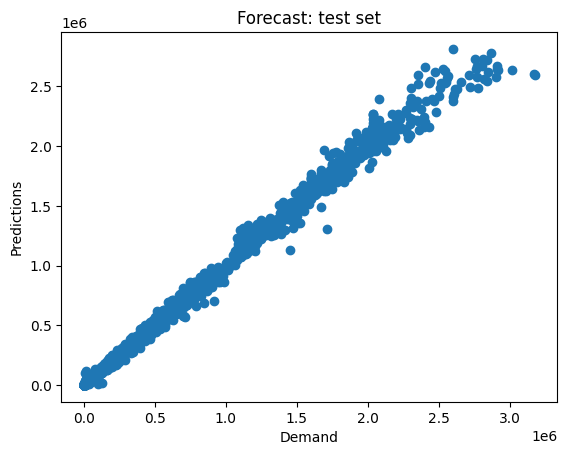

In [51]:
plt.scatter(y_test_t, preds_test)
plt.xlabel("Demand")
plt.ylabel("Predictions")
plt.title("Forecast: test set")

In [52]:
rmse_test = root_mean_squared_error(preds_test, y_test_t)

In [53]:
rmse_test

25942.155947585456

In [57]:
import numpy as np

def plot_residuals(y_train_pred, y_train, y_test_pred, y_test):

    x_max = np.max(
        [np.max(y_train_pred), np.max(y_test_pred)])
    x_min = np.min(
        [np.min(y_train_pred), np.min(y_test_pred)])
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(7, 3), sharey=True)
    ax1.scatter(
        y_test_pred, y_test_pred - y_test,
        c='limegreen', marker='s',
        edgecolor='white',
        label='Test data')
    ax2.scatter(
        y_train_pred, y_train_pred - y_train,
        c='steelblue', marker='o', edgecolor='white',
        label='Training data')
    ax1.set_ylabel('Residuals')
    for ax in (ax1, ax2):
        ax.set_xlabel('Predicted values')
        ax.legend(loc='upper left')
        ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100,\
            color='black', lw=2)
    plt.tight_layout()
    plt.show() 



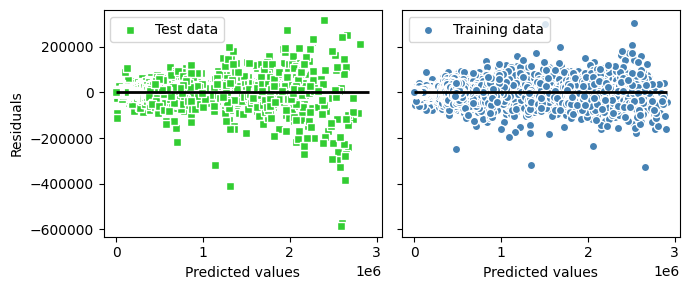

In [58]:
plot_residuals(preds, y_train_t, preds_test, y_test_t)